# Predicting Movie Likes and Dislikes

In [1]:
## All important imports go here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In this project we are attempting to view different models' ability to predict likes and dislikes of movies. Below we have downloaded a dataframe from Kaggle that includes different information about movies from 1986-2016. The information includes things such as genre, company, the name of the movie, runtime, etc. What concerns us most is the score column that is included in this dataframe. The movies were each given a score that was ranked out of 10, 10 being the best, 1 being the worst. We want to utilize these scores to be able to build and train a model to predict movies scores accurately. 

In [2]:
movies = pd.read_csv('movies.csv', encoding = 'latin-1') #Read in this data

In [3]:
movies.head() #Display dataframe

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [4]:
#Dropping unnecessary columns 
movies = movies.drop(columns =['country', 'rating', 'released', 'votes', 'writer', 'director', 'star'], axis =1)

In [5]:
avg_score = movies['score'].mean()

In [6]:
##Binarizing the movie ratings into zeros and ones for easy classification later on
movies['score'][movies['score'] < avg_score]= 0
movies['score'][movies['score'] > avg_score]= 1

<ipython-input-6-2812ab1c5f92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['score'][movies['score'] < avg_score]= 0
<ipython-input-6-2812ab1c5f92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['score'][movies['score'] > avg_score]= 1


We ran into an issue where around 1/3 of our data didn’t have budgets. In order to fill in this large gap in data we plotted a linear regression between the gross and budget columns generating a line of best fit. We then plugged the gross values into this best fit line to generate budgets for the films without them

In [7]:
##Doing a linear regression to find values to replace 0.0 in the budget column 
x = movies['gross']
y = movies['budget']

x_constant = sm.add_constant(x)
gross_budget_model = sm.OLS(y, x_constant)
results = gross_budget_model.fit()
print("Intercept and slope are:", results.params)

Intercept and slope are: const    9.404442e+06
gross    4.530648e-01
dtype: float64


In [8]:
m = results.params[0]
b = results.params[1]
#Replacing budgets of 0 with the budget values calculated in linear regression model
for i in range(movies.shape[0]):
    if movies['budget'][i] ==0.0:
        gross_val = movies['gross'][i]
        y = m*gross_val + b
        movies['budget'].iloc[i] = y

/Users/Bella/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
movies.head()

,budget,company,genre,gross,name,runtime,score,year
0,8000000.0,Columbia Pictures Corporation,Adventure,52287414.0,Stand by Me,89,1.0,1986
1,6000000.0,Paramount Pictures,Comedy,70136369.0,Ferris Bueller's Day Off,103,1.0,1986
2,15000000.0,Paramount Pictures,Action,179800601.0,Top Gun,110,1.0,1986
3,18500000.0,Twentieth Century Fox Film Corporation,Action,85160248.0,Aliens,137,1.0,1986
4,9000000.0,Walt Disney Pictures,Adventure,18564613.0,Flight of the Navigator,90,1.0,1986


In [10]:
#Doing OneHotEncoder for genre labels, this allows genres to be in zeros and ones so we can use them as features
#since they are no longer strings
encoder = OneHotEncoder()
genre = movies['genre']
genre_np = genre.to_numpy()
genre_ary = encoder.fit_transform(genre_np.reshape(-1,1)).toarray()

In [11]:
genre_df = pd.DataFrame(genre_ary)

In [12]:
genre_df = genre_df.rename({0:'Action', 1:'Adventure', 2:'Animation', 3:'Biography', 4:'Comedy', 5:'Crime', 
                            6:'Drama', 7:'Family', 8:'Fantasy', 9:'Horror', 10:'Musical', 11:'Mystery', 12:'Romance', 
                            13:'Sci-Fi', 14:'Thriller', 15:'War', 16:'Western'}, axis = 1)

In [13]:
movies_encoded = pd.concat([movies, genre_df], axis =1)
movies_encoded.head() #OneHotEncoder worked

,budget,company,genre,gross,name,runtime,score,year,Action,Adventure,...,Family,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,8000000.0,Columbia Pictures Corporation,Adventure,52287414.0,Stand by Me,89,1.0,1986,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6000000.0,Paramount Pictures,Comedy,70136369.0,Ferris Bueller's Day Off,103,1.0,1986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15000000.0,Paramount Pictures,Action,179800601.0,Top Gun,110,1.0,1986,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18500000.0,Twentieth Century Fox Film Corporation,Action,85160248.0,Aliens,137,1.0,1986,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9000000.0,Walt Disney Pictures,Adventure,18564613.0,Flight of the Navigator,90,1.0,1986,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cleaned_df = movies_encoded.drop(columns=['genre', 'company', 'name'], axis=1)
cleaned_df.head() #Cleaned dataframe ready for modeling

,budget,gross,runtime,score,year,Action,Adventure,Animation,Biography,Comedy,...,Family,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,8000000.0,52287414.0,89,1.0,1986,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6000000.0,70136369.0,103,1.0,1986,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15000000.0,179800601.0,110,1.0,1986,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18500000.0,85160248.0,137,1.0,1986,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9000000.0,18564613.0,90,1.0,1986,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualizing feature spaces

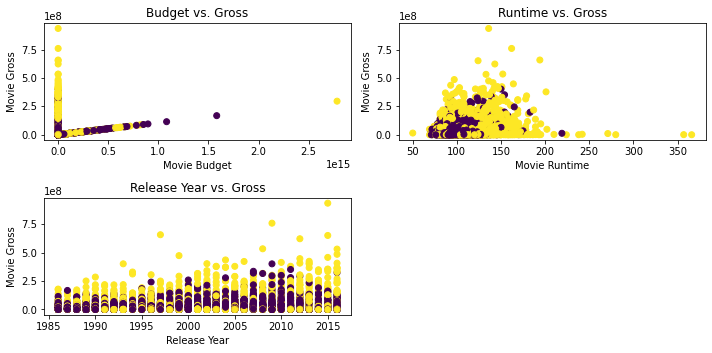

In [48]:
##Visualizing features to see if there are any patterns present before we start modeling
features = cleaned_df.drop(columns=['score'], axis =1)
labels = cleaned_df['score']

plt.figure(figsize=(10,7))
plt.subplot(321)
plt.scatter(features['budget'], features['gross'], c=labels)
plt.xlabel('Movie Budget')
plt.ylabel('Movie Gross')
plt.title('Budget vs. Gross')

plt.subplot(322)
plt.scatter(features['runtime'], features['gross'], c=labels)
plt.xlabel('Movie Runtime')
plt.ylabel('Movie Gross')
plt.title('Runtime vs. Gross')

plt.subplot(323)
plt.scatter(features['year'], features['gross'], c=labels)
plt.xlabel('Release Year')
plt.ylabel('Movie Gross')
plt.title('Release Year vs. Gross')

plt.tight_layout()

This is pretty hard to interpret. We can try scaling the features next to see if the visualization with be a little better than what is shown above. In previous In-class assignments, we have scaled features to be able to interpret and work with their visualizations in a much easier way. We will test this with our data next and see if it changes anything.

In [49]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [50]:
features_scaled = pd.DataFrame(features)

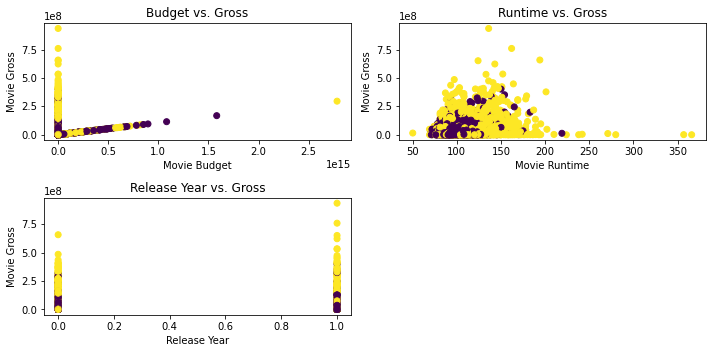

In [51]:
##Attempting the same visualization with scaled features
plt.figure(figsize=(10,7))
plt.subplot(321)
plt.scatter(features_scaled.iloc[:, 0], features_scaled.iloc[:, 1], c=labels)
plt.xlabel('Movie Budget')
plt.ylabel('Movie Gross')
plt.title('Budget vs. Gross')

plt.subplot(322)
plt.scatter(features_scaled.iloc[:, 2], features_scaled.iloc[:, 1], c=labels)
plt.xlabel('Movie Runtime')
plt.ylabel('Movie Gross')
plt.title('Runtime vs. Gross')

plt.subplot(323)
plt.scatter(features_scaled.iloc[:, 4], features_scaled.iloc[:, 1], c=labels)
plt.xlabel('Release Year')
plt.ylabel('Movie Gross')
plt.title('Release Year vs. Gross')

plt.tight_layout()

As we can see above, scaling the features did little to help us visualize the relationship between the features. It still is just as hard to interpret the visualization with scaled features as it was before the features were scaled. Now below just to see more visualizations, we can test the plots of the OneHotEncoder columns that we created for the different movie genres. 

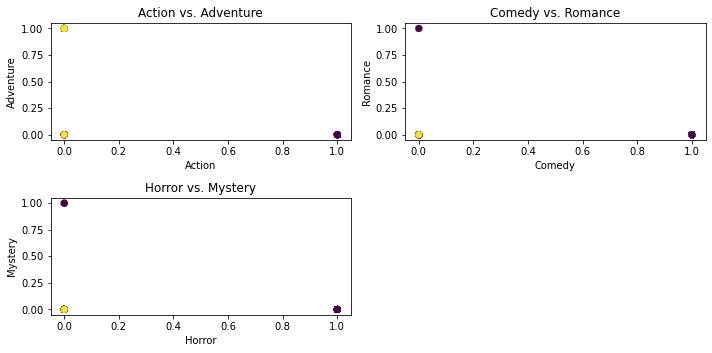

In [52]:
##Attempting to visualize OneHotEncoder columns 
#For this visualization we chose features that might seem to having overlapping genres, perhaps this might influence
# their ratings/score
plt.figure(figsize=(10,7))
plt.subplot(321)
plt.scatter(features['Action'], features['Adventure'], c=labels)
plt.xlabel('Action')
plt.ylabel('Adventure')
plt.title('Action vs. Adventure')

plt.subplot(322)
plt.scatter(features['Comedy'], features['Romance'], c=labels)
plt.xlabel('Comedy')
plt.ylabel('Romance')
plt.title('Comedy vs. Romance')

plt.subplot(323)
plt.scatter(features['Horror'], features['Mystery'], c=labels)
plt.xlabel('Horror')
plt.ylabel('Mystery')
plt.title('Horror vs. Mystery')

plt.tight_layout()

Due to the fact that there is only one genre associated with each movie, it makes it a lot harder to visualize the data in this manner. Perhaps if we did a heatmap of the correlations it might be easier to identify if there are any columns in the dataset that might have correlations with one another. 

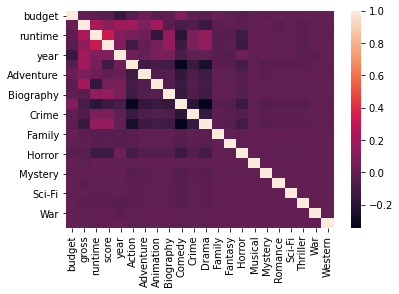

In [55]:
sns.heatmap(cleaned_df.corr())

Based on the color hue indicator on the right hand side of the figure we can see at a glance that none of the features have higher than 0.2/0.4 of a positive correlation with another given column. Some higher correlations present in the heatmap might be between runtime and gross as well as gross and year. But, as we saw in the feature space visualizations above, it's very difficult to be able to see any correlations or relationships between the features in the plots. 

## Logistic Regression

In [ ]:
# splitting the data, using 75% for training the model, random state is set for reproducibility
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            train_size = 0.75, random_state = 1)

With the training and testing sets of data for the unscaled features, a logistic model is made to try and predict whether a movie was liked or disliked. First, the logistic model is found by passing the classes and features for the training data into the Logit function from the statsmodels package. A constant is added to the training features for this model. Next, the model results can be viewed once it is fitted. Then, the test features can be be passed in to get the predictions from the fitted model. Finally, these predictions are matched up with the actual likes and dislikes to evaluate the performance of the model. If the predicted values were above 0.5, then they were classified as liked. Otherwise, they were dislikes. The accuracy score can be used to find the proportion of predictions that were correct.

In [ ]:
# creating the logistic regression model, adding a constant variable to the features
logit_model = sm.Logit(train_labels, sm.add_constant(train_features))

# fitting and evaluating the trained model
result = logit_model.fit()
print(result.summary())

temp = []
b = result.predict(sm.add_constant(test_features)) # have to loop through the results and sort the classes
for i in b:
    if i > 0.5: # if the prediction is higher than 0.5 then it is a like
        temp.append(1)
    else:
        temp.append(0)

print("The accuracy of the model is", accuracy_score(y_pred = temp,y_true= test_labels))
# accuracy of my model

From the accuracy score, it is evident that the accuracy of the model was not the best but it is significantly better than if the model was just left to chance. About 66% of movies were correctly guessed to have been liked or disliked. From the summary of the model, it seems that gross, run time, budget, and year are significant in predicting movie likes because their p-values are close to zero. One can also see that the genre categories and the constant were not very significant in the model. A simplified model can be made to try and increase accuracy without these insignificant features. After reducing the feature set and splitting the data into training and testing sets again, one can follow the previous methods to create the reduced logistic model.

In [ ]:
# dropping high p value features to make a reduced model
features2 = features.drop(columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
                            'Drama', 'Family', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Romance', 
                            'Sci-Fi', 'Thriller', 'War', 'Western'])


# splitting data again, sets of data and classes for training and testing
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels, 
                                                                                train_size = 0.75, random_state = 1)


logit_model2 = sm.Logit(train_labels2, train_features2) # my logistic model with the new training data, no constant


results2 = logit_model2.fit() # fitting the new model

temp2 = []
b = results2.predict(test_features2) # have to loop through the results and sort the classes
for i in b:
    if i > 0.5: # same threshold as before
        temp2.append(1)
    else:
        temp2.append(0)

        
print(results2.summary()) # printing the new results
print("The accuracy of the new model is", accuracy_score(y_pred = temp2,y_true= test_labels2))
# accuracy of my model

After reducing the model, it can be seen that the accuracy dropped a little, although it is nearly the same value as the full model. All in all, both of these models have some room for improvement if they even want to compare to the models the Netflix employs for predicting movies customers will like. One issue could be that the data is more complex than just a linear trend.

## KNN Classifier

In [ ]:
cols = features.columns

scaler = StandardScaler() #scale the data
features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns = cols)
features.describe()

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features,labels, random_state = 1,
                                                                            train_size = .75)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3) #creates the classifier with the neighbors #
fit = knn.fit(train_features,train_labels) #fits the training data
pred = fit.predict(test_features) #predicts the test data

print(confusion_matrix(test_labels, pred)) #evaluate the model with the confusion matrix, now using the test
print(accuracy_score(test_labels,pred)) #evaluate the model with the accuracy score, now using the test


fpr, tpr, thresholds = roc_curve(test_labels,pred)
plt.plot(fpr,tpr, "mx-",)
plt.plot([0, 1], [0, 1],'c--')
plt.xlabel("FPR") #false positive rate
plt.ylabel("TPR") #true positive rate

auc = roc_auc_score(test_labels, pred) #area under the curve; closer to 1 the better
print("auc:",auc)

The KNN classifier shows a fairly low accuracy in predicting the movie likes and dislikes based on the scoring data. The confusion matrix shows about 379 false positives predicitons, the number of predictions that were falsely catagorized as a 'liked' movie, and 369 false negatives, the number of predicaitons falsely catagorized as dislikes. Additionally, the ROC cuve shows a line only slighly greater than .5, meaning the predictions are just a little better than a guess. Based on these results, the KNN may not be the best classifier for the scored data.

## SVM with RBF kernel

In [ ]:
svc_linear = SVC(C = .1, kernel = 'rbf', gamma = 10) 
svc_linear.fit(train_features, train_labels) 
pred2 = svc_linear.predict(test_features) 


print(accuracy_score(test_labels,pred2))
print(confusion_matrix(test_labels,pred2))


fpr, tpr, thresholds = roc_curve(test_labels,pred2) 
plt.plot(fpr,tpr, "mx-")
plt.plot([0, 1], [0, 1],'c--')
plt.xlabel("FPR")
plt.ylabel("TPR")

auc = roc_auc_score(test_labels, pred2)
print("auc:",auc)

As shown above our ROC curve is the same as the chance line and our AUC is .5. So for an SVC with default parameters and an rbf kernel, the classification of movie likes and dislikes is as accurate as guessing.

## Random Forest

In [ ]:
#not using the scaled data
train_feature, test_feature, train_label, test_label = train_test_split(features,labels, random_state = 1,
                                                                            train_size = .75)

In [ ]:
x,y = make_classification()
forest = RandomForestClassifier(max_depth=2, random_state=1)
forest.fit(train_feature, train_label) 
pred3 = forest.predict(test_feature) 


print(accuracy_score(test_label,pred3))
print(confusion_matrix(test_label,pred3))


fpr, tpr, thresholds = roc_curve(test_label,pred3) 
plt.plot(fpr,tpr, "mx-")
plt.plot([0, 1], [0, 1],'c--')
plt.xlabel("FPR")
plt.ylabel("TPR")

auc = roc_auc_score(test_label, pred3)
print("auc:",auc)

The Random forest classifier is used to make up for the failure of the SVM. The random forest is better able to handle the binarized data. The Random forest classifier uses a number of decision trees to settle on a single result or classification . Each decision tree creates subsections of the data based on its features, and these subsections are then used to predict new values. This model showed an accuracy score of about 62%, with the area under the ROC curve being 0.61. The model also reports about 456 false positives and 189 false negatives. Overall, this is not the most ideal accuracy however the random forest does show more reasonable results than the SVM.

## Grid Search CV

After splitting the data into training and testing sets, I used the training data and a list of hyper parameters in order to determine which of these hyper parameters are the best for our model. I found that the best parameters were a C value of 1, a gamma value of .1, and a RBF kernel  I then used these best Parameters in a grid search to get an accuracy of .54 with 785 false positives and 920 negatives. This is really bad, and the model is basically guessing (:

In [ ]:
#Create features and labels
features = movies['score']
labels = cleaned_df
labels

In [ ]:
#Split data!
ltrain, ltest, ftrain, ftest = train_test_split(features, labels, random_state=1, train_size = .75)
print(len(ftrain),len(ltrain),len(ftest),len(ltest))
ltest.shape
print(ltrain)

In [ ]:
params = {'C': [1,10,100,1000], 'gamma': [.1,.01,.001,.0001], 'kernel':['rbf']}
grid = GridSearchCV(SVC(),param_grid = params)
grid.fit(ftrain,ltrain)
grid_predictions = grid.predict(ftest)
print(grid.best_params_)

In [ ]:
params = {'C': [1], 'gamma': [.1], 'kernel':['rbf']}
grid = GridSearchCV(SVC(),param_grid = params)
grid.fit(ftrain,ltrain)
grid_prediction = grid.predict(ftest)
print(confusion_matrix(ltest,grid_prediction),classification_report(ltest,grid_prediction))

## PCA

In [15]:
features = cleaned_df.drop(columns=['score'], axis =1)
labels = cleaned_df['score']

In [16]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(features, labels, train_size =.75,
                                                                         test_size = .25, random_state =1)

We will first create a PCA model using kernel rbf along with C=10 and gamma=0.1. We will be using kernel = 'rbf' for our PCAs because this kernel works better with non-linear data and as we have shown in our feature space visualizations, our data does not seem to be following any sort of linear pattern. We will also includes 10 components for this PCA which is fewer than the number of features in our dataset.

In [25]:
##Creating and fiting PCA model, first using 10 components
pca = PCA(n_components=10, whiten=True, random_state =1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [26]:
##Now fitting model using SVC with kernel rbf with C=10 and gamma=0.1
pca_svm = SVC(kernel ='rbf', C=10, gamma = 0.1, random_state =1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred = pca_model.predict(pca_test_vectors)

In [27]:
#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred))
print('The classification report is \n', classification_report(test_labels, pca_ypred))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred))

The confusion matrix is 
 [[466 319]
 [243 677]]
The classification report is 
               precision    recall  f1-score   support

         0.0       0.66      0.59      0.62       785
         1.0       0.68      0.74      0.71       920

    accuracy                           0.67      1705
   macro avg       0.67      0.66      0.67      1705
weighted avg       0.67      0.67      0.67      1705

The accuracy score is 
 0.6703812316715543


Now, we will attempt to make a PCA that has the same number of components as features in our dataset. We will then see if the accuracy scores change at all with this change in number of components. We will keep the kernel as rbf as well as the same C and gamma values in the first PCA. 

In [28]:
##Creating and fiting PCA model, now using 21 components, which is equal to the number of features in our dataset
pca = PCA(n_components=21, whiten=True, random_state =1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [29]:
##Now fitting model using SVC with kernel rbf with C=10 and gamma=0.1
pca_svm = SVC(kernel ='rbf', C=10, gamma = 0.1, random_state =1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred21 = pca_model.predict(pca_test_vectors)

In [30]:
#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred21))
print('The classification report is \n', classification_report(test_labels, pca_ypred21))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred21))

The confusion matrix is 
 [[473 312]
 [234 686]]
The classification report is 
               precision    recall  f1-score   support

         0.0       0.67      0.60      0.63       785
         1.0       0.69      0.75      0.72       920

    accuracy                           0.68      1705
   macro avg       0.68      0.67      0.67      1705
weighted avg       0.68      0.68      0.68      1705

The accuracy score is 
 0.6797653958944282


In [31]:
print('The accuracy score of the PCA with 10 components is \n', accuracy_score(test_labels, pca_ypred))
print('The accuracy score of the PCA with 21 components is \n', accuracy_score(test_labels, pca_ypred21))

The accuracy score of the PCA with 10 components is 
 0.6703812316715543
The accuracy score of the PCA with 21 components is 
 0.6797653958944282


As we can see in the cell above, the accuracy score for both PCAs, one with 10 components and one with 21 components, are pretty much equal. If we look more closely we can see that the accuracy for 21 components is slightly higher than the accuracy for 10 components. This might indicate that we might need to use fewer components and to get a better accuracy since after 10 components the accuracies are relatively the same. Perhaps once we pass 10 components we might be overfitting the data, so it might be a good idea to try a PCA with fewer components, for example 4. The number of features that do not include the OneHotEncoder we did of the genres is four features, so maybe that would be a good number less than 10 that we could try.

In [32]:
#Trying a PCA with 4 components to see if we were overfitting with 10 components
pca = PCA(n_components=4, whiten=True, random_state = 1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [33]:
##Now fitting model using SVC with kernel rbf with C=10 and gamma=0.1
pca_svm = SVC(kernel ='rbf', C=10, gamma = 0.1, random_state =1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred4 = pca_model.predict(pca_test_vectors)

In [34]:
#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred4))
print('The classification report is \n', classification_report(test_labels, pca_ypred4))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred4))

The confusion matrix is 
 [[502 283]
 [279 641]]
The classification report is 
               precision    recall  f1-score   support

         0.0       0.64      0.64      0.64       785
         1.0       0.69      0.70      0.70       920

    accuracy                           0.67      1705
   macro avg       0.67      0.67      0.67      1705
weighted avg       0.67      0.67      0.67      1705

The accuracy score is 
 0.6703812316715543


In [35]:
print('The accuracy score for a PCA with 4 components is \n', accuracy_score(test_labels, pca_ypred4))
print('The accuracy score of the PCA with 10 components is \n', accuracy_score(test_labels, pca_ypred))
print('The accuracy score of the PCA with 21 components is \n', accuracy_score(test_labels, pca_ypred21))

The accuracy score for a PCA with 4 components is 
 0.6703812316715543
The accuracy score of the PCA with 10 components is 
 0.6703812316715543
The accuracy score of the PCA with 21 components is 
 0.6797653958944282


This didn't work either. The accuracy with 4 components seems to be the same as the accuracy with 10 components. However, one interesting thing to look at is the confusion matrix for all three models. 

In [36]:
print('The confusion matrix for a PCA with 4 components is \n', confusion_matrix(test_labels, pca_ypred4))
print('The confusion matrix for a PCA with 21 components is \n', confusion_matrix(test_labels, pca_ypred21))
print('The confusion matrix for a PCA with 10 components is \n', confusion_matrix(test_labels, pca_ypred))

The confusion matrix for a PCA with 4 components is 
 [[502 283]
 [279 641]]
The confusion matrix for a PCA with 21 components is 
 [[473 312]
 [234 686]]
The confusion matrix for a PCA with 10 components is 
 [[466 319]
 [243 677]]


As we can see above the confusion matrix has the higher accuracy of true positives for the PCA with 4 components and the lowest number of true positives for the PCA with 10 components. Overall, there are still a lot of false positives and false negatives present in all of the confusion matrices regardless of component number so we still have a really low accuracy for all versions of the PCA. One reason that we might have low accuracy in our models is because we have feature spaces that do not have positive correlations with one another, and therefore they do not have a strong relationship with one another. Since our dataset does not have strong relationships between different columns it would make it a lot harder to build an accurate model using the features that we currently have.  

# POSSIBLE DELETION TOMORROW


From a previous section of code, we were able to calculate the best possible parameters with GridSearch. The best parameters that were found were C=1, gamma =.1, and kernel ='rbf'. Now we can use these parameters for our PCA. In this case we will use PCA with 21 components because in comparison to the other PCAs the PCA with 21 components had the highest accuracy score and the second highest number of true positives in the confusion matrix. This is also the number of features that are present in our dataset.

In [ ]:
#Trying a PCA with 21 components to test best parameters
pca = PCA(n_components=21, whiten=True, random_state =1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

In [ ]:
#Adjusting parameters to match calculated best parameters from GridSearch
pca_svm = SVC(kernel ='rbf', C=1, gamma = 0.1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred21_best = pca_model.predict(pca_test_vectors)

In [ ]:
#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred21_best))
print('The classification report is \n', classification_report(test_labels, pca_ypred21_best))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred21_best))

As we can see above, the accuracy for the model took a slight downturn in comparison to the previous SVC parameters. One thing that contrasts with the lower accuracy is that the number of true positives went up in the confusion matrix. Let's compare these metrics to the metrics of our PCA with 4 components that did not account for the best parameters.

In [ ]:
print('The confusion matrix with best parameters and 21 components is \n',
      confusion_matrix(test_labels, pca_ypred21_best))
print('The confusion matrix with 21 components is \n', confusion_matrix(test_labels, pca_ypred21))
print('The accuracy score with best parameters and 21 components is \n',
      accuracy_score(test_labels, pca_ypred21_best))
print('The accuracy score with 21 components is \n', accuracy_score(test_labels, pca_ypred21))

In [ ]:
drop_accuracy = accuracy_score(test_labels, pca_ypred21) - accuracy_score(test_labels, pca_ypred21_best)
print('The drop in accuracy between the two PCAs is \n', round(drop_accuracy, 6))
diff_confusion = confusion_matrix(test_labels, pca_ypred21_best) - confusion_matrix(test_labels, pca_ypred21)
print('The difference in confusion matrices between PCAs is \n', diff_confusion)

As we can see here, there was a slight drop in accuracy in the model. The drop in accuracy was around .009384 which is pretty close to 0. This means our best parameters model did worse than the default parameters model, keeping the same number of components (21) each time. Also calculating the difference between the confusion matrices, we can see that there was low increase in true positives but also larger increase in false negatives. This increase in false negatives or misclassifications might be where our accuracy score took a dip in comparison to the model using default parameters. Overall, these metrics don't really show the best parameters found via GridSearch helped build us a better model. 

# END POSSIBLE DELETION

### Updated Best Parameters 

From a previous section of code, we were able to calculate the best possible parameters with GridSearch. The best parameters that were found were C=1, gamma =.1, and kernel ='poly'. Now we can use these parameters for our PCA. In this case we will use PCA with 21 components because in comparison to the other PCAs the PCA with 21 components had the highest accuracy score and the second highest number of true positives in the confusion matrix. This is also the number of features that are present in our dataset.

In [44]:
#Trying a PCA with 21 components to test best parameters
pca = PCA(n_components=21, whiten=True, random_state =1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

#Adjusting parameters to match calculated best parameters from GridSearch
pca_svm = SVC(kernel ='poly', C=1, gamma = 0.1, random_state = 1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred_poly = pca_model.predict(pca_test_vectors)

#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred_poly))
print('The classification report is \n', classification_report(test_labels, pca_ypred_poly))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred_poly))

The confusion matrix is 
 [[480 305]
 [259 661]]
The classification report is 
               precision    recall  f1-score   support

         0.0       0.65      0.61      0.63       785
         1.0       0.68      0.72      0.70       920

    accuracy                           0.67      1705
   macro avg       0.67      0.66      0.67      1705
weighted avg       0.67      0.67      0.67      1705

The accuracy score is 
 0.669208211143695


As we can see above there is a slight dip in the accuracy score using the best parameters. There are also over 300 false positives and 259 false negatives, so this model still has a lot of misclassifications. Next we'll compare the metrics of this model to a PCA with the same kernel along with C and gamma values we used previously.

In [45]:
#Trying a PCA with 21 components to test best parameters
pca = PCA(n_components=21, whiten=True, random_state =1)
pca = pca.fit(train_vectors)

##Now transforming train and test vectors into PCA train and test vectors
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

#Adjusting parameters to match calculated best parameters from GridSearch
pca_svm = SVC(kernel ='poly', C=10, gamma = 0.1, random_state = 1)
pca_model = pca_svm.fit(pca_train_vectors, train_labels)
pca_ypred_21poly = pca_model.predict(pca_test_vectors)

#Now printing metrics to look at accuracy of model
print('The confusion matrix is \n', confusion_matrix(test_labels, pca_ypred_21poly))
print('The classification report is \n', classification_report(test_labels, pca_ypred_21poly))
print('The accuracy score is \n', accuracy_score(test_labels, pca_ypred_21poly))

The confusion matrix is 
 [[476 309]
 [260 660]]
The classification report is 
               precision    recall  f1-score   support

         0.0       0.65      0.61      0.63       785
         1.0       0.68      0.72      0.70       920

    accuracy                           0.67      1705
   macro avg       0.66      0.66      0.66      1705
weighted avg       0.67      0.67      0.67      1705

The accuracy score is 
 0.6662756598240469


In [46]:
print('The confusion matrix with best parameters and 21 components is \n',
      confusion_matrix(test_labels, pca_ypred_poly))
print('The confusion matrix with 21 components is \n', confusion_matrix(test_labels, pca_ypred_21poly))
print('The accuracy score with best parameters and 21 components is \n',
      accuracy_score(test_labels, pca_ypred_poly))
print('The accuracy score with 21 components is \n', accuracy_score(test_labels, pca_ypred_21poly))

The confusion matrix with best parameters and 21 components is 
 [[480 305]
 [259 661]]
The confusion matrix with 21 components is 
 [[476 309]
 [260 660]]
The accuracy score with best parameters and 21 components is 
 0.669208211143695
The accuracy score with 21 components is 
 0.6662756598240469


It's fairly hard to tell if the PCAs accuracy scores are any different here, so we will do some math to be able to further determine if there was any change in accuracy by using the best fit parameters from GridSearch.

In [47]:
drop_accuracy = accuracy_score(test_labels, pca_ypred_21poly) - accuracy_score(test_labels, pca_ypred_poly)
print('The drop in accuracy between the two PCAs is \n', round(drop_accuracy, 6))
diff_confusion = confusion_matrix(test_labels, pca_ypred_21poly) - confusion_matrix(test_labels, pca_ypred_poly)
print('The difference in confusion matrices between PCAs is \n', diff_confusion)

The drop in accuracy between the two PCAs is 
 -0.002933
The difference in confusion matrices between PCAs is 
 [[-4  4]
 [ 1 -1]]


As shown in the cell above, there was actually almost no difference in accuracy score or the confusion matrix values when using best fit parameters found via GridSearch. The accuracy score with best parameters was only slightly higher than the accuracy score without and it was very close to zero. The confusion matrix actually gained some true positive values when going from the PCA without best parameters to the PCA with best parameters.

### PCA Conclusion: 

Overall, we were able to look at how different numbers of components influenced our model metrics and accuracy. In comparing PCAs with 4, 10, 21 components all with an rbf kernel and C=10, gamma=0.1 parameters, we found that the PCA with 21 components had the best highest accuracy score and second highest number of true positives in the confusion matrix. Testing our PCA model with 21 components and the best parameters calculated previously using GridSearchCV we found ultimately no difference in metrics between the two models, any differences that presented themselves were very slight. Altogether, there is a very small almost not visible improvement in metrics when using the best parameters in our PCA. 

# Possible Limitations: Netflix Comparison

Predicting a movie someone may like or dislike is similar to what the streaming site Netflix does for each viewer's profile. However, Netflix has access to much more personalized data such as all the other shows and movies someone watches and sometimes what rating they give it. Additionally, Netflix has information about other viewers who may watch similar things and can then recommend a movie based on things that these viewers have in common. They also factor in things such as the duration and times someone uses the site for, as well as the devices they watch on. All of these inputs are used to create more specific and more accurate recommendations. Additionally, within each different category on the home page such as "Trending now" or "Comedies", Netflix arranges these rows in order of which movie is most likely to be enjoyed by that specific viewer. So each column in the rows start with the movie Netflix recommends most in that category, even though it is not in the "Recommended" category. Furthermore, the most strongly recommended rows go on top of the home screen, so both the rows and columns of each profile is laid out in a way that puts Netflix's highest recommendations in the front. All this sorting is why it is said that there are "33 million different versions of Netflix", one personalized for each viewer. To be able to create so many predictions and sort movies in such a strong, personalized way is why Netflix needs all these specific factors, and to compare viewers with similar taste. Without this information it would be much more difficult and less accurate to predict a movie someone may like.

#### Sources:

https://help.netflix.com/en/node/100639

https://neilpatel.com/blog/how-netflix-uses-analytics/